# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [25]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [36]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')
customers.shape

(440, 8)

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [27]:
# Your code here:
customers.shape
customers.head()
customers.isnull().sum() #No null values
customers.dtypes#all numeric
customers.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [28]:
print("min\n", customers.min(), "\n\nmax\n",customers.max(),"\n\nMEAN\n",customers.mean(), "\n\nSTD\n",customers.std() )

min
 Channel              1
Region               1
Fresh                3
Milk                55
Grocery              3
Frozen              25
Detergents_Paper     3
Delicassen           3
dtype: int64 

max
 Channel                  2
Region                   3
Fresh               112151
Milk                 73498
Grocery              92780
Frozen               60869
Detergents_Paper     40827
Delicassen           47943
dtype: int64 

MEAN
 Channel                 1.322727
Region                  2.543182
Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicassen           1524.870455
dtype: float64 

STD
 Channel                 0.468052
Region                  0.774272
Fresh               12647.328865
Milk                 7380.377175
Grocery              9503.162829
Frozen               4854.673333
Detergents_Paper     4767.854448
Delicassen           2820.105937
dtyp

In [31]:
# Your observations here
customers.corr()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


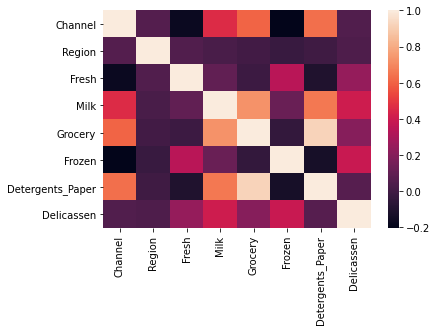

In [30]:
sns.heatmap(customers.corr())

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [34]:
#To find outliers I do this: 
from scipy import stats
customers[(np.abs(stats.zscore(customers)) < 3).all(axis=1)]

#I had 44O rows, now I have 414

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


### That do this: 
For each column, first it computes the Z-score of each value in the column, relative to the column mean and standard deviation.
Then is takes the absolute of Z-score because the direction does not matter, only if it is below the threshold.
all(axis=1) ensures that for each row, all column satisfy the constraint.
Finally, result of this condition is used to index the dataframe.

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [37]:
# Your import here:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(customers)
customers_scale = scaler.transform(customers)

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [57]:
# Your code here:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)

labels = model.fit_predict(customers)

customers["labels"] = labels
customers.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,2,-1
1,2,3,7057,9810,9568,1762,3293,1776,2,-1
2,2,3,6353,8808,7684,2405,3516,7844,2,-1
3,1,3,13265,1196,4221,6404,507,1788,2,-1
4,2,3,22615,5410,7198,3915,1777,5185,1,-1


Count the values in `labels`.

In [58]:
# Your code here:


# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [59]:
# Your code here
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps = 0.5).fit(customers)
labels_DBSCAN = clustering.labels_
customers["labels_DBSCAN"]=labels_DBSCAN
customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,2,-1
1,2,3,7057,9810,9568,1762,3293,1776,2,-1
2,2,3,6353,8808,7684,2405,3516,7844,2,-1
3,1,3,13265,1196,4221,6404,507,1788,2,-1
4,2,3,22615,5410,7198,3915,1777,5185,1,-1
...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,1,-1
436,1,3,39228,1431,764,4510,93,2346,1,-1
437,2,3,14531,15488,30243,437,14841,1867,0,-1
438,1,3,10290,1981,2232,1038,168,2125,2,-1


Count the values in `labels_DBSCAN`.

In [60]:
# Your code here

customers["labels_DBSCAN"].value_counts()

-1    440
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

Text(0, 0.5, 'Milk')

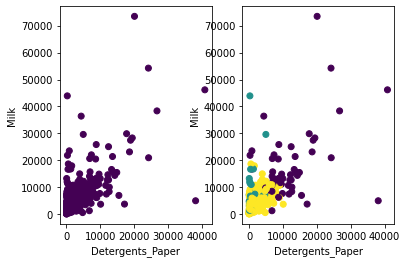

In [61]:
# Your code here:

plt.subplots
plt.subplot(1,2,1)
plt.scatter(customers["Detergents_Paper"],customers["Milk"],c=customers["labels_DBSCAN"] )
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")
plt.subplot(1,2,2)
plt.scatter(customers["Detergents_Paper"],customers["Milk"],c=customers["labels"])
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")



Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

Text(0, 0.5, 'Fresh')

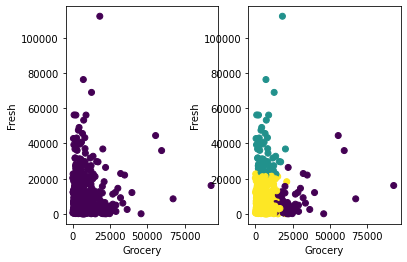

In [62]:
plt.subplots
plt.subplot(1,2,1)
plt.scatter(customers["Grocery"],customers["Fresh"],c=customers["labels_DBSCAN"] )
plt.xlabel("Grocery")
plt.ylabel("Fresh")
plt.subplot(1,2,2)
plt.scatter(customers["Grocery"],customers["Fresh"],c=customers["labels"])
plt.xlabel("Grocery")
plt.ylabel("Fresh")

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

Text(0, 0.5, 'Delicassen')

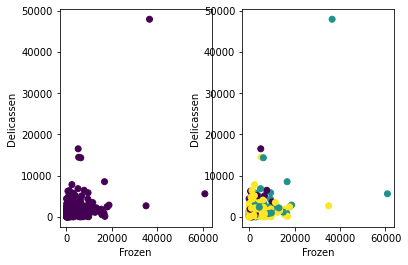

In [63]:
# Your code here:
plt.subplots
plt.subplot(1,2,1)
plt.scatter(customers["Frozen"],customers["Delicassen"],c=customers["labels_DBSCAN"] )
plt.xlabel("Frozen")
plt.ylabel("Delicassen")
plt.subplot(1,2,2)
plt.scatter(customers["Frozen"],customers["Delicassen"],c=customers["labels"])
plt.xlabel("Frozen")
plt.ylabel("Delicassen")


Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [64]:
# Your code here:
group_by_labels = customers.groupby(["labels"]).agg("mean")
group_by_labels

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,,,
0,1.962264,2.471698,7751.981132,17910.509434,27037.905660,1970.943396,12104.867925,2185.735849,-1.0
1,1.135593,2.593220,36156.389831,6123.644068,6366.779661,6811.118644,1050.016949,3090.050847,-1.0
2,1.253049,2.545732,8341.612805,3779.893293,5152.173780,2577.237805,1720.573171,1136.542683,-1.0


In [65]:
group_by_labels_DBSCAN = customers.groupby(["labels_DBSCAN"]).agg("mean")
group_by_labels_DBSCAN

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,,
-1,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,1.625


Which algorithm appears to perform better?

In [67]:
# Your observations here
#I guess Kmeans as it differentiates  groups better

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here